# CA4 - Stellar object classification

### Import libraries 

In [50]:
# import libraries for plotting and data manipulation
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

# import classfier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# import model selection and preprocessing tools 
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score


### Reading the data 

In [23]:
# load training and test data 
training_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

### Data exploration 

#### Look at the shape of the data

In [24]:
# check the shape of the data 
training_data.shape, test_data.shape

((80000, 18), (20000, 17))

We can see by the shape of the data, that the training and test data is split 80/20 

#### Overview of the data 

In [25]:
training_data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


The data has 17 columns, where the class column is the class of the stellar object, our target variable y. 

#### Visualize feature distributions using violinplots 

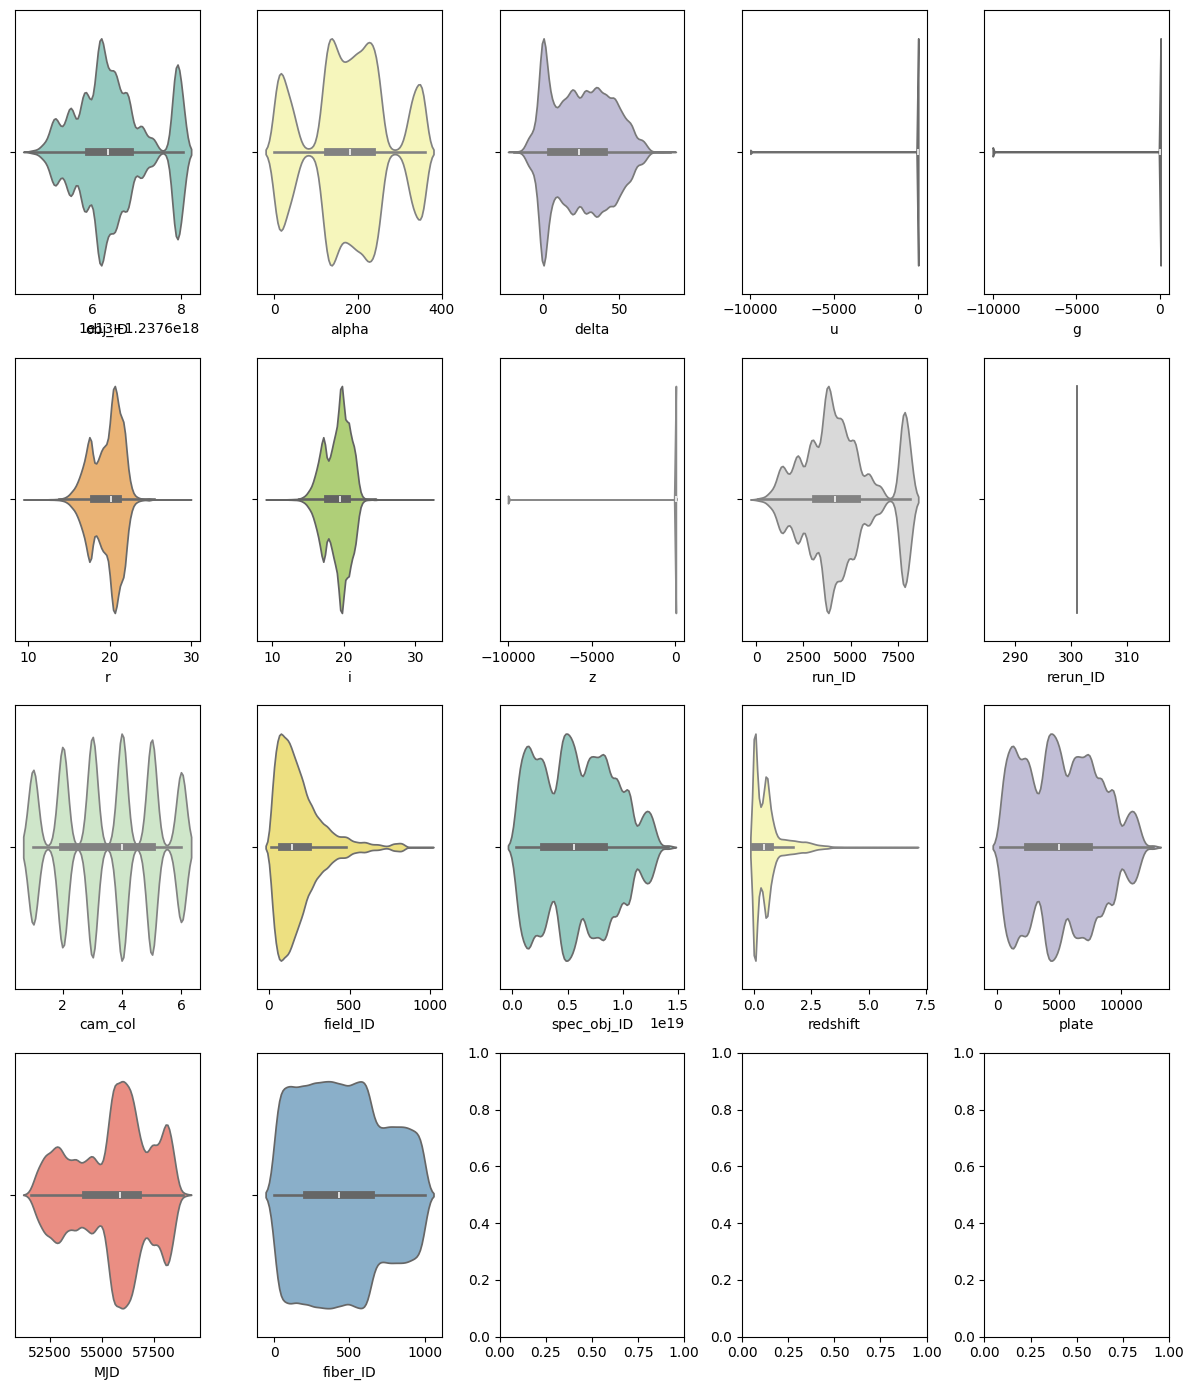

In [26]:
# visualize feature distributions 
fig, axes = plt.subplots(4,5, figsize = (12,14)) 
axes = axes.flatten() 

columns = training_data.columns.to_list()
columns = [col for i, col in enumerate(columns) if i != 13]  

colors = sns.color_palette('Set3', n_colors=len(columns)) 

for i, col in enumerate(columns):
    sns.violinplot(x=col, data=training_data, ax=axes[i], color=colors[i])

plt.tight_layout()
plt.show()

#### Perform descriptive statistics 

In [27]:
training_data.describe() 

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,8.000000e+04,80000.000000,80000.000000,79638.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.0,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000
mean,1.237665e+18,177.579220,24.132590,21.961115,20.507677,19.647426,19.085051,18.644640,4477.876713,301.0,3.511388,185.663050,5.783094e+18,0.577219,5136.309963,55587.191400,448.887437
std,8.424878e+12,96.409584,19.650113,35.581856,35.483302,1.855636,1.757630,35.462189,1961.579187,0.0,1.589033,148.433559,3.327780e+18,0.731597,2955.646539,1809.144282,272.328619
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995801e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.643892,5.170723,20.353990,18.963188,18.135523,17.732600,17.457503,3185.000000,301.0,2.000000,82.000000,2.841535e+18,0.055160,2523.750000,54233.000000,221.000000
50%,1.237663e+18,180.761747,23.603480,22.187965,21.101015,20.127550,19.405635,19.004420,4188.000000,301.0,4.000000,146.000000,5.606066e+18,0.425051,4979.000000,55868.000000,432.000000
75%,1.237668e+18,233.815698,39.904905,23.698457,22.125007,21.047242,20.401857,19.923013,5326.000000,301.0,5.000000,240.000000,8.331746e+18,0.704777,7400.000000,56777.000000,644.000000
max,1.237681e+18,359.999615,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


### Data cleaning

#### Look for missing values 

In [28]:
# identify rows with missing values
NaN = training_data.isna().sum()
print(NaN)

print(f'Missing values in the training data: {NaN[3]}')

obj_ID           0
alpha            0
delta            0
u              362
g                0
r                0
i                0
z                0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID      0
class            0
redshift         0
plate            0
MJD              0
fiber_ID         0
dtype: int64
Missing values in the training data: 362


C:\Users\anekl\AppData\Local\Temp\ipykernel_8884\2165697918.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Missing values in the training data: {NaN[3]}')


#### Remove missing values from the training data 

In [29]:
# remove rows with missing values
training_data_clean = training_data.dropna()

# check if there are any missing values left
training_data_clean.isna().sum()

print(f'Missing values left in the training data: {training_data_clean.isna().sum().sum()}')

Missing values left in the training data: 0


#### Remove excessive features from the data set 

In [30]:
training_data_clean = training_data_clean.drop(columns=['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'MJD', 'fiber_ID', 'plate', 'fiber_ID'])
training_data_clean.head()

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123


In [31]:
# remove excessive features from the test data 
test_data_clean = test_data.drop(columns=['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'MJD', 'fiber_ID', 'plate', 'fiber_ID'])
test_data_clean.head()

,alpha,delta,u,g,r,i,z,redshift
0,16.956890,3.646130,23.33542,21.95143,20.48149,19.60300,19.13094,0.506237
1,240.063240,6.134131,17.86033,16.79228,16.43001,16.30923,16.25873,0.000345
2,30.887222,1.188710,18.18911,16.89469,16.42161,16.24627,16.18549,0.000004
3,247.594401,10.887780,24.99961,21.71203,21.47148,21.30532,21.29109,-0.000291
4,18.896451,-5.261330,23.76648,21.79737,20.69543,20.23403,19.97464,-0.000136


##### Visualize feature distributions after removing excessive features 

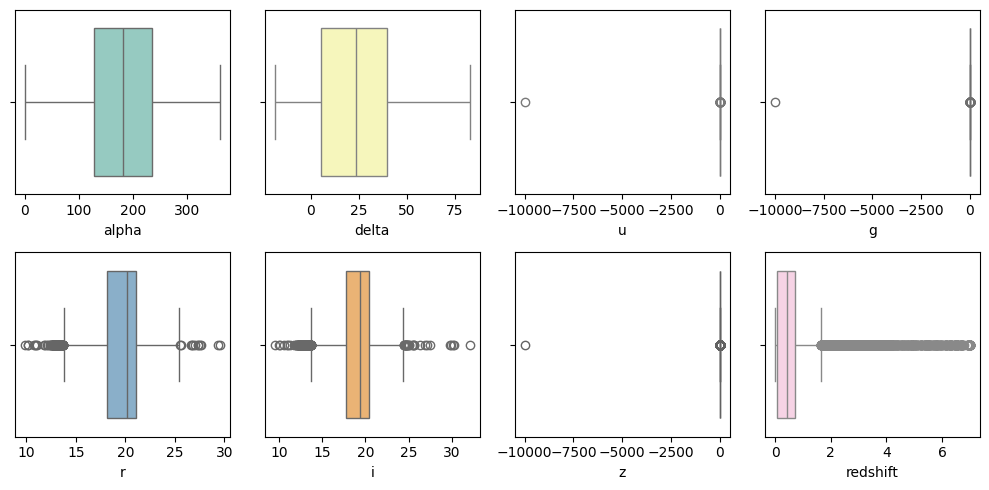

In [32]:
# visualize feature distributions 
fig, axes = plt.subplots(2,4, figsize = (10,5)) 
axes = axes.flatten() 

columns = training_data_clean.columns.to_list()
columns = [col for i, col in enumerate(columns) if i != 7]  

colors = sns.color_palette('Set3', n_colors=len(columns)) 

for i, col in enumerate(columns):
    sns.boxplot(x=col, data=training_data_clean, ax=axes[i], color=colors[i])

plt.tight_layout()
plt.show()


##### Visualization using violinplots 

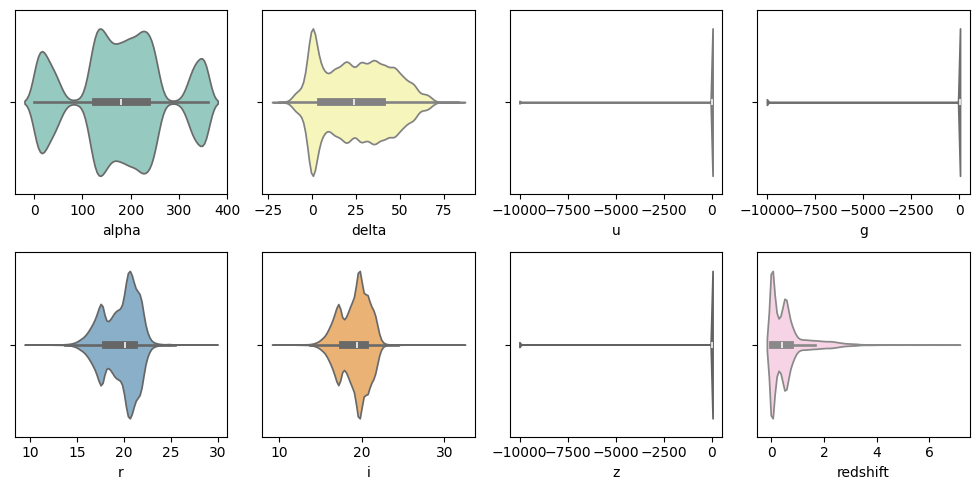

In [33]:
# visualize feature distributions 
fig, axes = plt.subplots(2,4, figsize = (10,5)) 
axes = axes.flatten() 

columns = training_data_clean.columns.to_list()
columns = [col for i, col in enumerate(columns) if i != 7]  

colors = sns.color_palette('Set3', n_colors=len(columns)) 

for i, col in enumerate(columns):
    sns.violinplot(x=col, data=training_data_clean, ax=axes[i], color=colors[i])

plt.tight_layout()
plt.show()

#### Visualize the feature relationships using pairplots from seaborn 

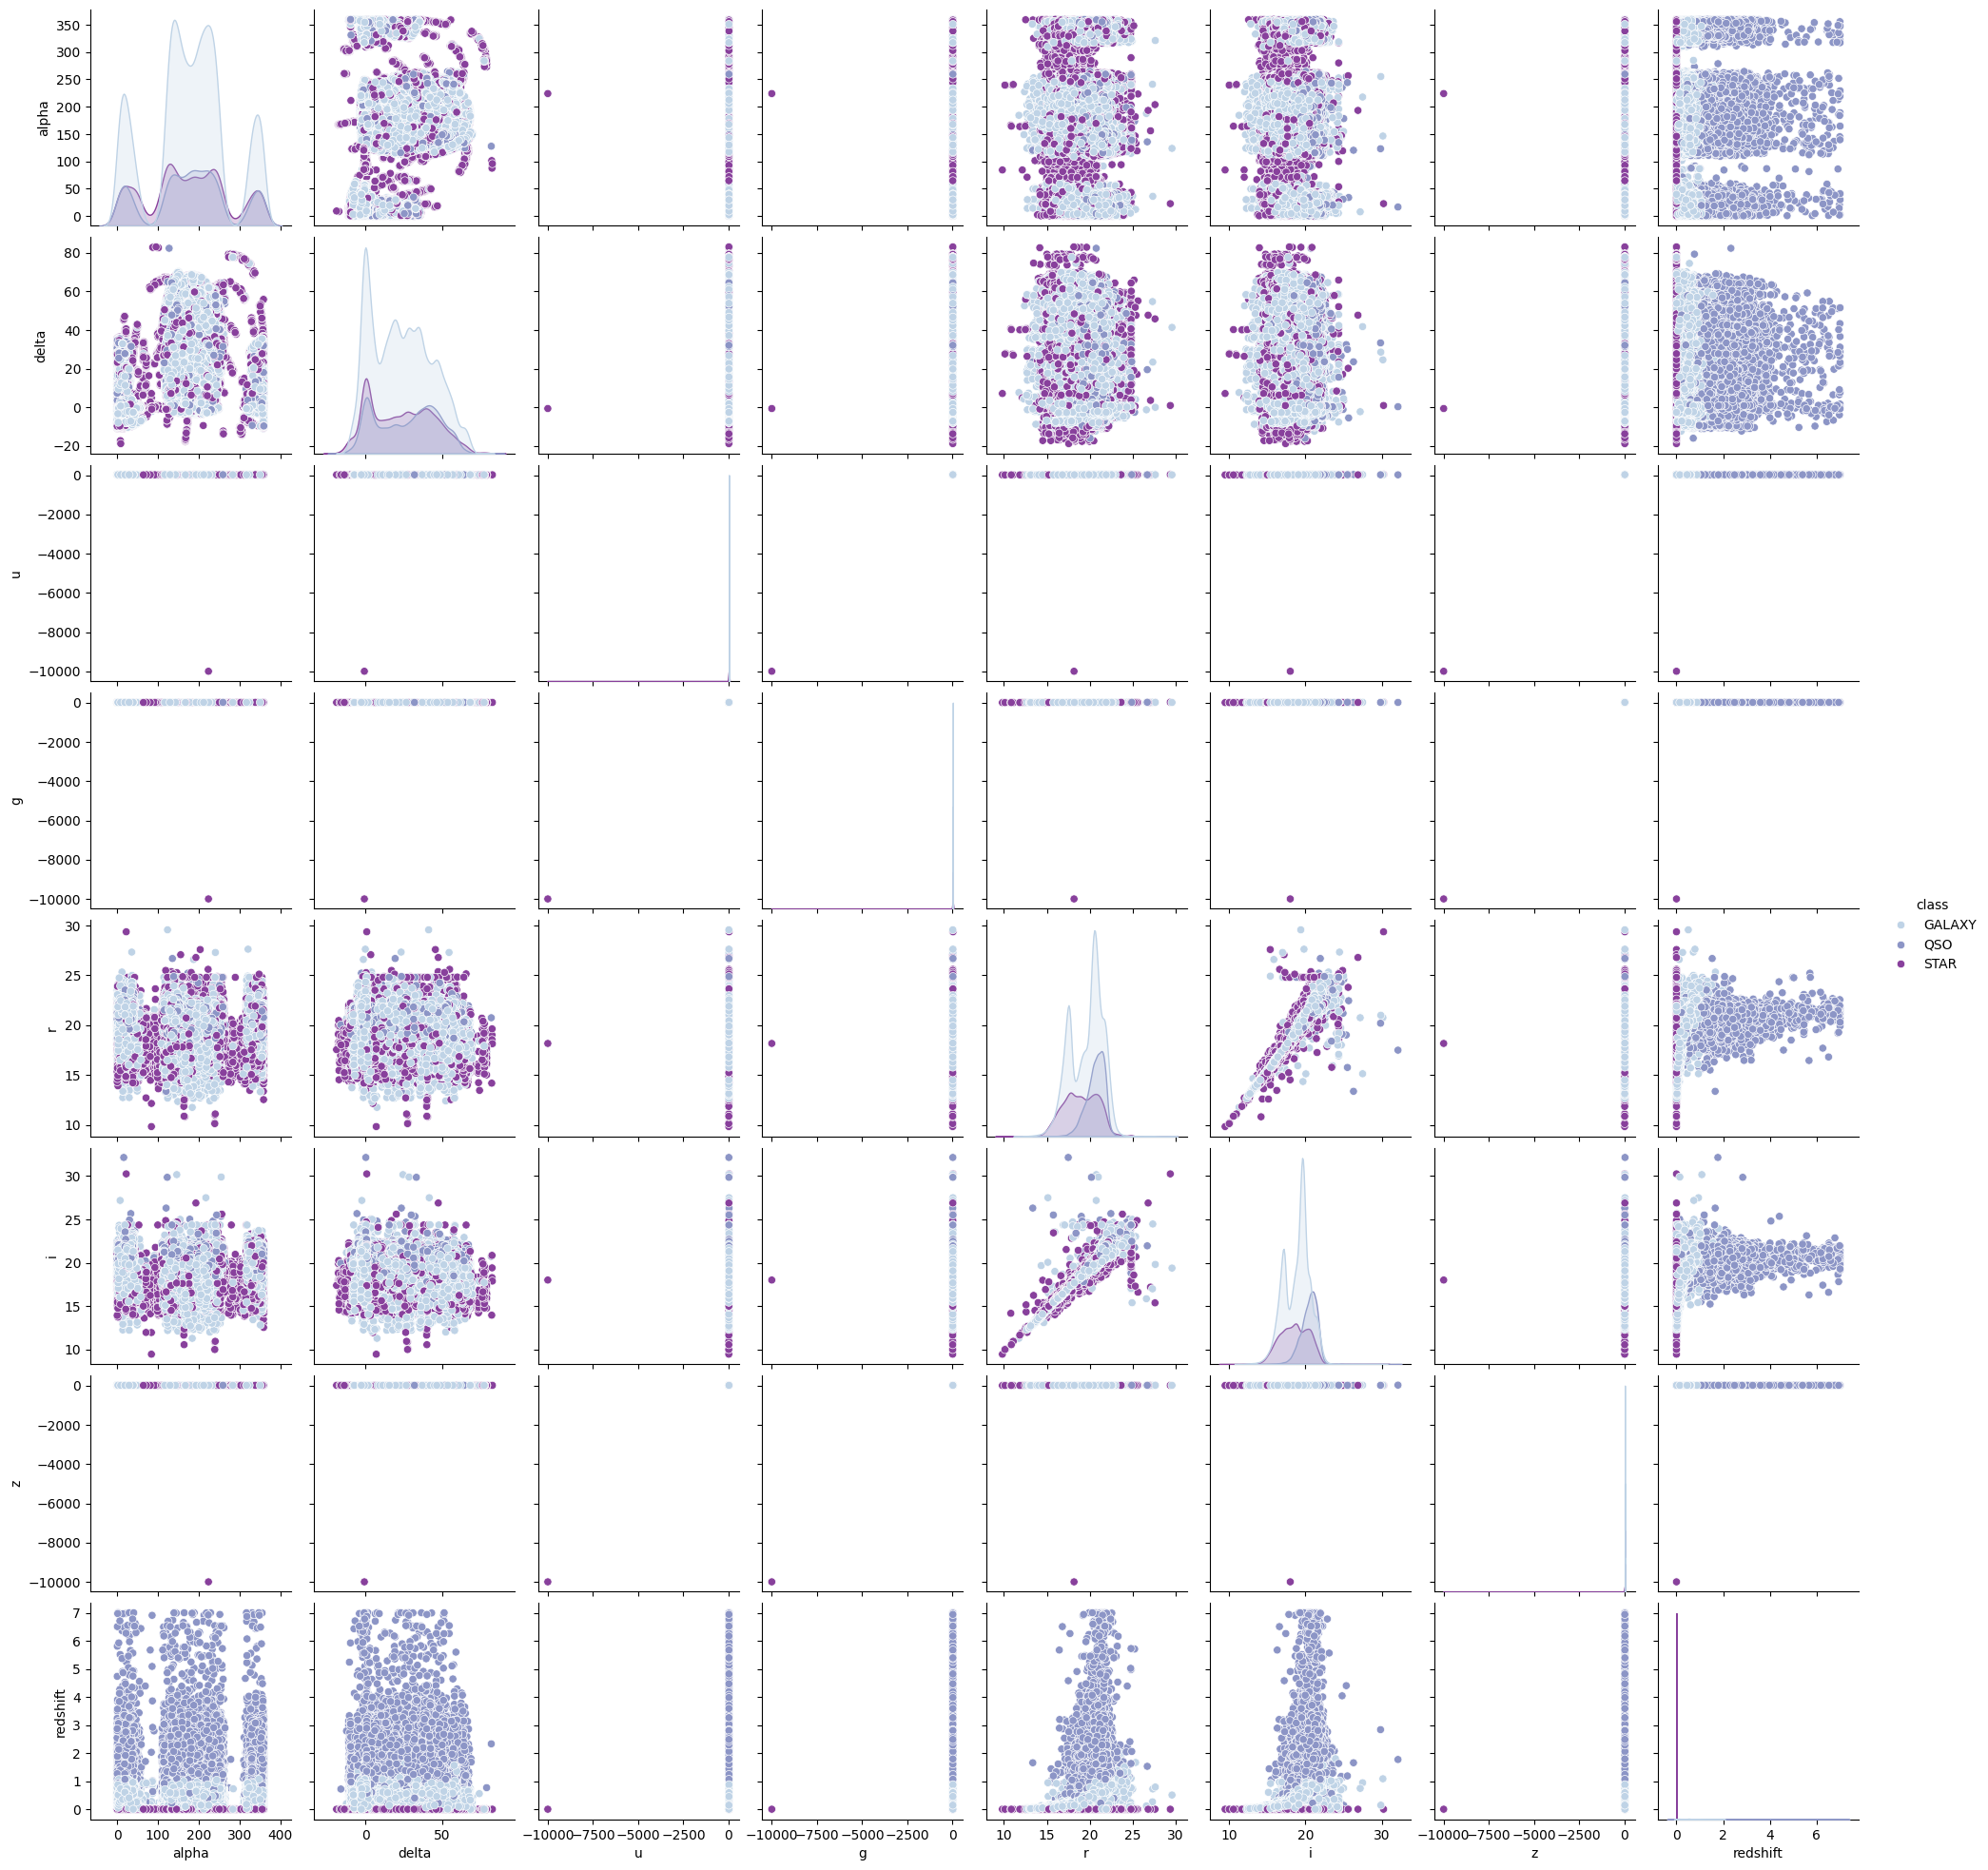

In [34]:
# make a pairplot of the training data 
sns.pairplot(training_data_clean, hue = 'class', palette= 'BuPu')
plt.show()

We can see that the features are highly different in their distributions, and therefore should be scaled/standardized. 

### Data preprocessing and visualization 

#### Split the training data into X_train and y_train

In [35]:
X_train = training_data_clean.drop(columns=['class'])
y_train = training_data_clean['class']
X_train.shape, y_train.shape

((79638, 8), (79638,))

#### Transform the categorical class variable using LabelEncoder 

In [36]:
le = LabelEncoder() 
# encode the target variable
y_train = le.fit_transform(y_train)
le.classes_

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [37]:
le.transform(['GALAXY', 'QSO', 'STAR']) 

array([0, 1, 2])

#### Look at the target variable distribution 

In [38]:
(f'The distribution of the target variable is: {np.bincount(y_train)}')

'The distribution of the target variable is: [47585 14802 17251]'

C:\Users\anekl\AppData\Local\Temp\ipykernel_8884\2183804107.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='BuPu')


Text(0.5, 0, 'Class')

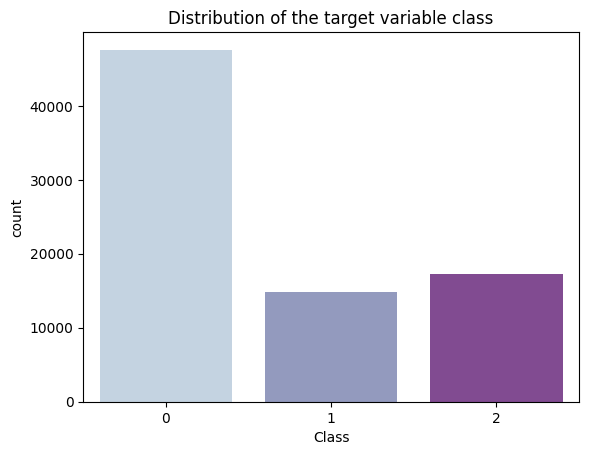

In [39]:
sns.countplot(x=y_train, palette='BuPu')
plt.title('Distribution of the target variable class')
plt.xlabel('Class')

We can see from the plot above that the target variable is quite unbalanced, with more than half of the samples in the first class, galaxy. 

#### Visualize the features before removing outliers

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'delta'}>, <Axes: title={'center': 'u'}>],
       [<Axes: title={'center': 'g'}>, <Axes: title={'center': 'r'}>,
        <Axes: title={'center': 'i'}>],
       [<Axes: title={'center': 'z'}>,
        <Axes: title={'center': 'redshift'}>, <Axes: >]], dtype=object)

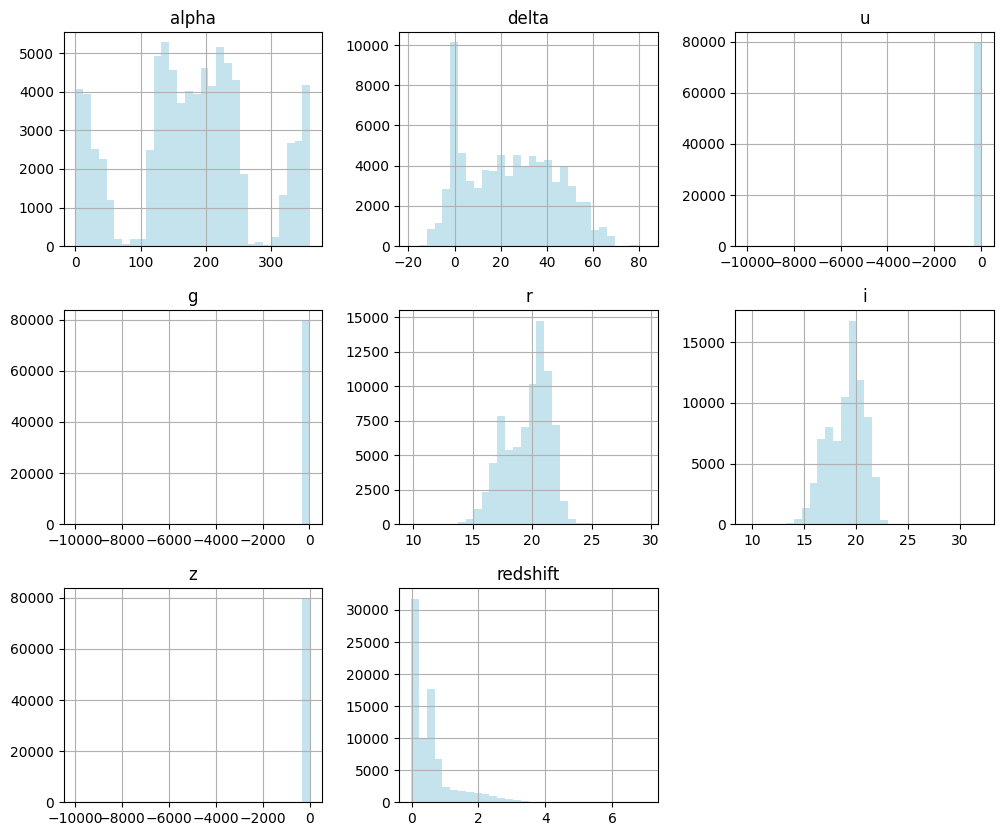

In [40]:
X_train.hist(figsize=(12, 10), bins=30, color='lightblue', alpha=0.7)

#### Identify and remove outliers using Z-score 

In [41]:
# Detect outliers using z-scores 

# Compute Z-scores
z_scores = (X_train - X_train.mean()) / X_train.std()

# Identify Outliers (absolute Z-score > 3)
outliers = (np.abs(z_scores) > 3)

# Count total outliers
num_outliers = outliers.sum().sum()  # Summing over all columns

print(f"Total number of outliers: {num_outliers}")


Total number of outliers: 1831


In [42]:
if isinstance(y_train, np.ndarray):
    y_train = pd.Series(y_train, index=X_train.index)

# Filter rows where all features have Z-score < 3
X_train_clean = X_train[(np.abs(z_scores) < 3).all(axis=1)]

# Remove corresponding rows from y_train
y_train_clean = y_train.loc[X_train_clean.index]

# Print the shapes of the original and cleaned datasets
print("Original X_train shape:", X_train.shape)
print("Original y_train shape:", y_train.shape)
print("Cleaned X_train shape:", X_train_clean.shape)
print("Cleaned y_train shape:", y_train_clean.shape)

Original X_train shape: (79638, 8)
Original y_train shape: (79638,)
Cleaned X_train shape: (77943, 8)
Cleaned y_train shape: (77943,)


#### Visualize the features after removing outliers 

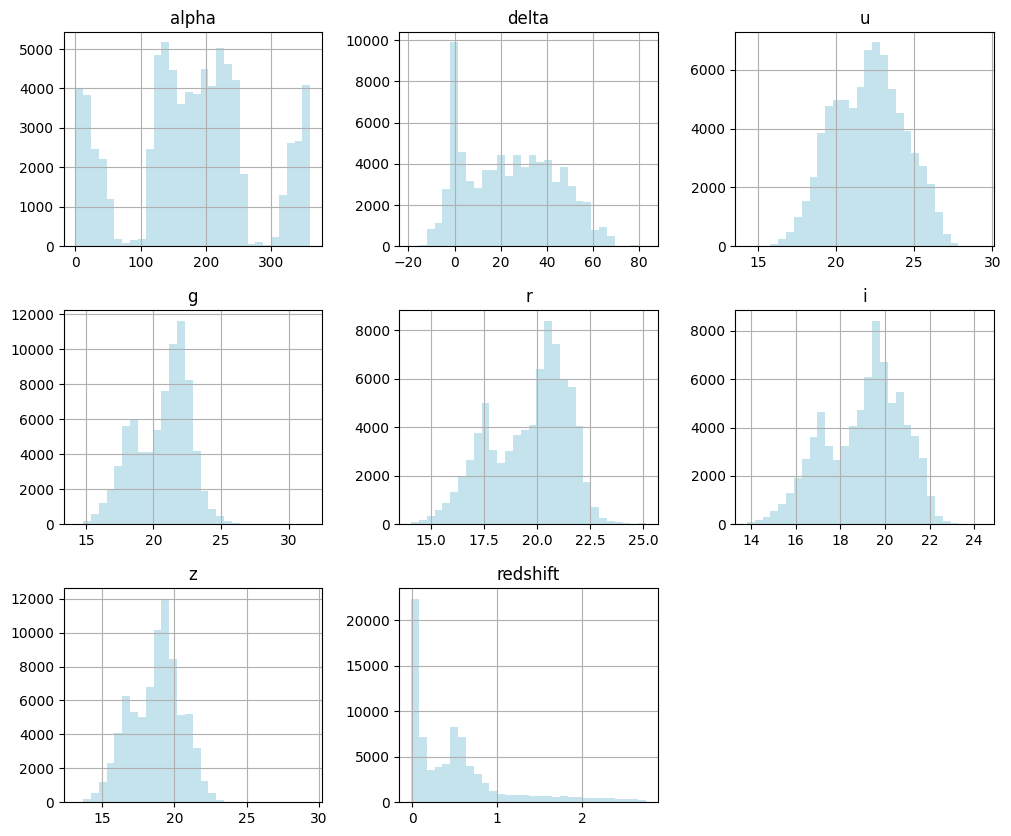

In [43]:
histogram = X_train_clean.hist(figsize=(12, 10), bins=30, color='lightblue', alpha=0.7)

#### Visualize the data before scaling 

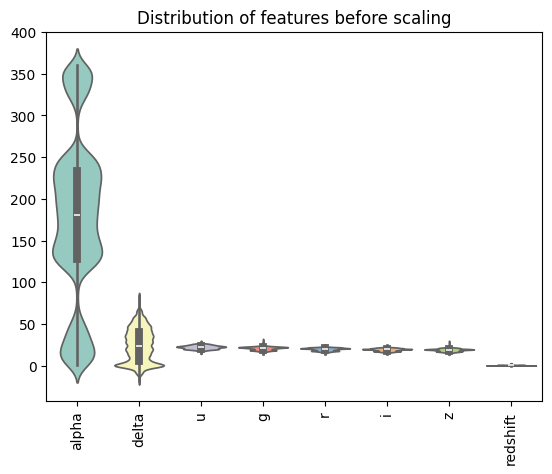

In [44]:
sns.violinplot(X_train_clean, palette = sns.color_palette('Set3', n_colors= X_train_clean.shape[1])) 
plt.xticks(rotation = 90)
plt.title('Distribution of features before scaling')
plt.show()

### Modelling 

#### Define pipelines 

##### SVM 

In [45]:
# Define the SVC pipeline: 
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
pipe_svc.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('svc', SVC(random_state=1))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(random_state=1),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': 1,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

##### Logistic regression 

In [46]:
# Define the logistic regression pipeline:
pipe_logistic = make_pipeline(StandardScaler(), PCA(n_components=7), LogisticRegression(random_state=1))
pipe_logistic.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('pca', PCA(n_components=7)),
  ('logisticregression', LogisticRegression(random_state=1))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'pca': PCA(n_components=7),
 'logisticregression': LogisticRegression(random_state=1),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'pca__copy': True,
 'pca__iterated_power': 'auto',
 'pca__n_components': 7,
 'pca__n_oversamples': 10,
 'pca__power_iteration_normalizer': 'auto',
 'pca__random_state': None,
 'pca__svd_solver': 'auto',
 'pca__tol': 0.0,
 'pca__whiten': False,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs

##### Random Forest

In [47]:
# Define the random forest pipeline: 
pipe_rf = make_pipeline(RandomForestClassifier(random_state=1)) 
pipe_rf.get_params()

{'memory': None,
 'steps': [('randomforestclassifier', RandomForestClassifier(random_state=1))],
 'verbose': False,
 'randomforestclassifier': RandomForestClassifier(random_state=1),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__monotonic_cst': None,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_state': 1,
 'randomforestc

##### K-nearest-neighbour (KNN) 

In [48]:
# Define the KNN pipeline: 
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
pipe_knn.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

#### Evaluate different models and hyperparameters using GridSearchCV with cross-validation 

##### SVM 

In [53]:

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_svm = GridSearchCV(estimator=pipe_svc,
                  param_grid={'svc__C': [0.1, 1, 10, 100], 'svc__kernel': ['rbf']},
                  scoring='f1_macro',
                  cv=cv_strategy,
                  n_jobs=-1)

gs_svm = gs_svm.fit(X_train_clean, y_train_clean)
print(gs_svm.best_score_)
print(gs_svm.best_params_)

best_model_svm = gs_svm.best_estimator_

0.9666694954815223
{'svc__C': 100, 'svc__kernel': 'rbf'}


##### Logistic regression 

In [52]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_logistic = GridSearchCV(estimator=pipe_logistic, 
                  param_grid={'logisticregression__penalty': ['l2'], 
                              'logisticregression__C': [1,10,100]},
                  scoring='f1_macro',
                  cv=cv_strategy,
                  n_jobs=-1)

gs_logistic = gs_logistic.fit(X_train_clean, y_train_clean)
print(gs_logistic.best_score_)
print(gs_logistic.best_params_)

best_model_logistic = gs_logistic.best_estimator_

0.9529143717852919
{'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}


##### Random forest 

In [54]:
gs_rf = GridSearchCV(estimator=pipe_rf,
                  param_grid={'randomforestclassifier__n_estimators': [80, 100, 120],
                              'randomforestclassifier__max_features': ['sqrt', 'log2'],
                              'randomforestclassifier__max_depth': [5,10,15],
                              'randomforestclassifier__criterion': ['entropy']}, 
                  scoring='f1_macro',
                  cv=5,
                  n_jobs=-1)

gs_rf = gs_rf.fit(X_train_clean, y_train_clean) 
print(gs_rf.best_score_)
print(gs_rf.best_params_)

best_model_rf = gs_rf.best_estimator_ 

0.9730246117133078
{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__n_estimators': 80}


##### KNN 

In [55]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs_knn = GridSearchCV(estimator=pipe_knn, 
                  param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7],
                              'kneighborsclassifier__weights': ['distance'],
                              'kneighborsclassifier__metric': ['euclidean', 'manhattan']},
                  scoring='f1_macro',
                  cv=cv_strategy,
                  n_jobs=-1)

gs_knn = gs_knn.fit(X_train_clean, y_train_clean)
print(gs_knn.best_score_)
print(gs_knn.best_params_)

best_model_knn = gs_knn.best_estimator_

0.9404996981321396
{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}


#### Build classifier based on all training samples using the "optimal parameters"

The code below is based on the best model of the Random Forest Classifier, since this had the highest score during GridSearch. 


All fitting, predicting and evaluation is done using this classifier. 

In [56]:
# fit the best model to the training data (random forest) 
best_model_rf.fit(X_train_clean, y_train_clean) 


Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=15,
                                        max_features='log2', n_estimators=80,
                                        random_state=1))])

### Evaluate model performance  

##### Confusion matrix 

In [57]:
# confusion matrix for the random forest model using train/test split on training data
X_train_data, X_test_data, y_train_labels, y_testlabels = train_test_split(X_train_clean, y_train_clean, test_size=0.4, random_state=42) 
y_pred = best_model_rf.predict(X_test_data) 

confusion = confusion_matrix(y_testlabels, y_pred)
confusion 


array([[18771,    38,     1],
       [  160,  5295,     0],
       [    0,     0,  6913]])

##### Plot the confusion matrix using matplotlib 

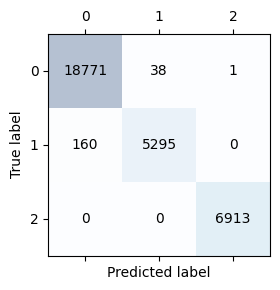

In [58]:
# Code borrowed from lecture 'Chapter_6_part_2b' 

fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax.text(x=j, y=i, s=confusion[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

Model performance using classification report in Scikit learn 

In [59]:
classification_rep = pd.DataFrame(classification_report(y_testlabels, y_pred, output_dict=True)).T
classification_rep

,precision,recall,f1-score,support
0,0.991548,0.997927,0.994727,18810.000000
1,0.992875,0.970669,0.981646,5455.000000
2,0.999855,1.000000,0.999928,6913.000000
accuracy,0.993617,0.993617,0.993617,0.993617
macro avg,0.994759,0.989532,0.992100,31178.000000
weighted avg,0.993622,0.993617,0.993592,31178.000000


We can see that the output from the classification report gave the same F1 scores as we manually calculated above.

### Kaggle submission 

In [60]:
y_test = best_model_rf.predict(test_data_clean)
y_test = pd.DataFrame(y_test, columns=["class"])
y_test.index.name = "ID"
y_test[['class']].to_csv("data/sample_submission.csv")